# 1. Load Dataset

In [36]:
%matplotlib inline

import time
import datetime

import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('googleplaystore.csv')

In [3]:
df.head(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


# 2. Data Cleaning, Visualization and Analysis

In [4]:
df.dropna(how='any', inplace=True)
df.drop_duplicates(['App'], inplace=True)
df.shape

(8190, 13)

## 2.1 Ratings Overview

In [5]:
df['Rating'].describe()

count    8190.000000
mean        4.173321
std         0.536691
min         1.000000
25%         4.000000
50%         4.300000
75%         4.500000
max         5.000000
Name: Rating, dtype: float64

Text(0, 0.5, 'Frequency')

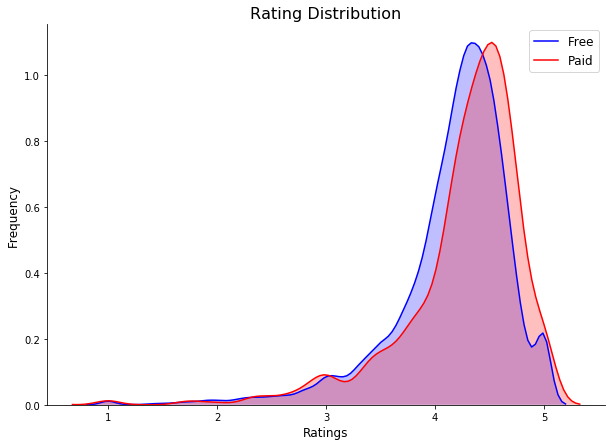

In [6]:
f, ax = plt.subplots(figsize=(10, 7))
sns.despine(f)
sns.kdeplot(df[df['Type']=='Free']['Rating'], color = 'b', shade=True)
sns.kdeplot(df[df['Type']=='Paid']['Rating'], color = 'r', shade=True)
plt.title('Rating Distribution', size=16)
plt.legend(['Free', 'Paid'], fontsize=12)
plt.xlabel('Ratings', size=12)
plt.ylabel('Frequency', size=12)

The average of the ratings is around 4.2 which is a high rating score.

## 2.2 Category - Rating

In [8]:
print(df['Category'].describe())
print('\nUnique Categories: \n', df['Category'].unique())

count       8190
unique        33
top       FAMILY
freq        1607
Name: Category, dtype: object

Unique Categories: 
 ['ART_AND_DESIGN' 'AUTO_AND_VEHICLES' 'BEAUTY' 'BOOKS_AND_REFERENCE'
 'BUSINESS' 'COMICS' 'COMMUNICATION' 'DATING' 'EDUCATION' 'ENTERTAINMENT'
 'EVENTS' 'FINANCE' 'FOOD_AND_DRINK' 'HEALTH_AND_FITNESS' 'HOUSE_AND_HOME'
 'LIBRARIES_AND_DEMO' 'LIFESTYLE' 'GAME' 'FAMILY' 'MEDICAL' 'SOCIAL'
 'SHOPPING' 'PHOTOGRAPHY' 'SPORTS' 'TRAVEL_AND_LOCAL' 'TOOLS'
 'PERSONALIZATION' 'PRODUCTIVITY' 'PARENTING' 'WEATHER' 'VIDEO_PLAYERS'
 'NEWS_AND_MAGAZINES' 'MAPS_AND_NAVIGATION']


Text(0, 0.5, 'Frequency')

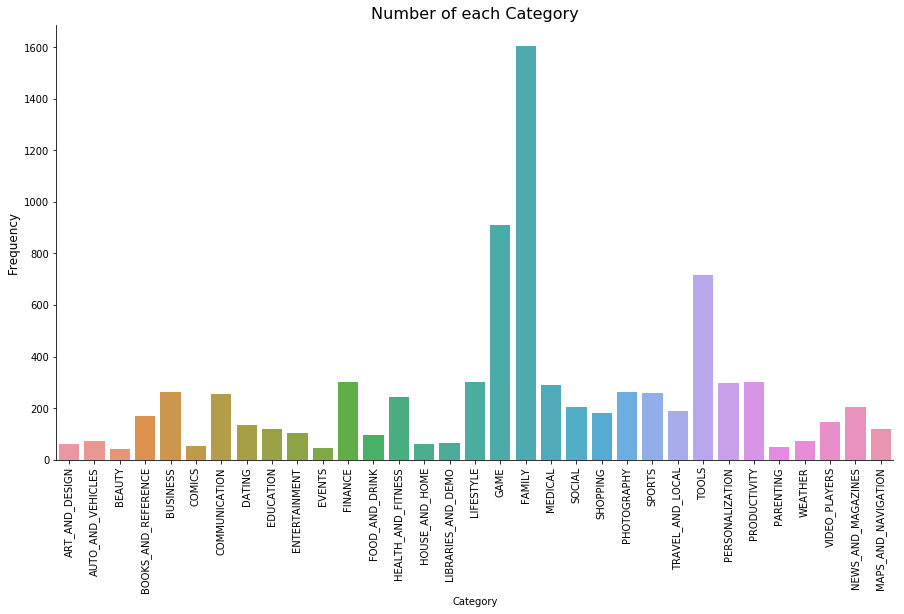

In [9]:
f, ax = plt.subplots(figsize=(15, 8))
sns.despine(f)
sns.countplot(x='Category', data = df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title('Number of each Category', size=16)
# plt.xlabel('Ratings', size=12)
plt.ylabel('Frequency', size=12)

Most App belongs to "Game" and "Family" Category

Text(0.5, 1.0, 'Rating vs Category')

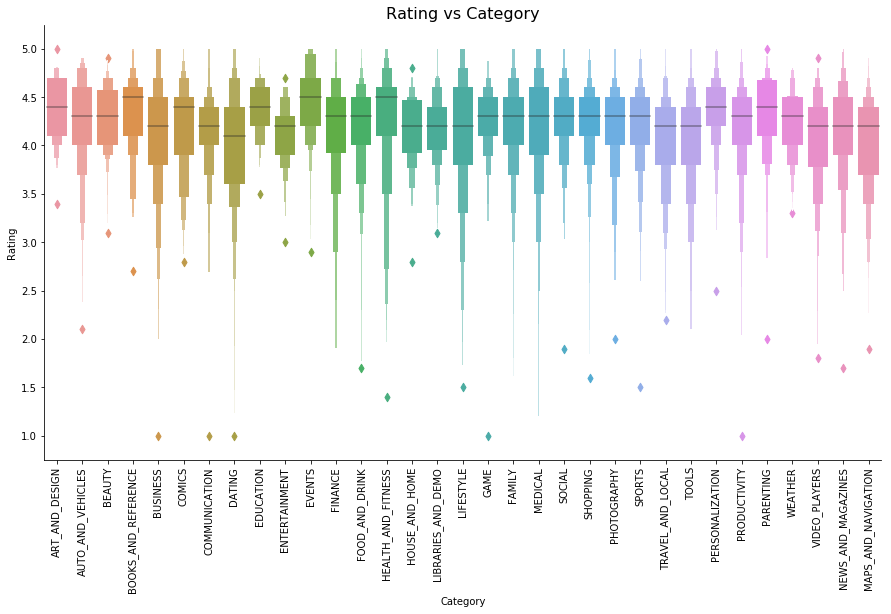

In [10]:
f, ax = plt.subplots(figsize=(15, 8))
sns.despine(f)
sns.boxenplot(x='Category', y='Rating', data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title('Rating vs Category', size=16)

The average rating of each category doesn't various too much. Almost all of them are around 4.0 ~ 4.5

## 2.3 Reviews - Rating

In [11]:
df['Reviews'] = df['Reviews'].apply(lambda x : int(x))
df['Reviews'].describe()

count    8.190000e+03
mean     2.554354e+05
std      1.986309e+06
min      1.000000e+00
25%      1.260000e+02
50%      3.009500e+03
75%      4.391425e+04
max      7.815831e+07
Name: Reviews, dtype: float64

Text(0, 0.5, 'Frequency')

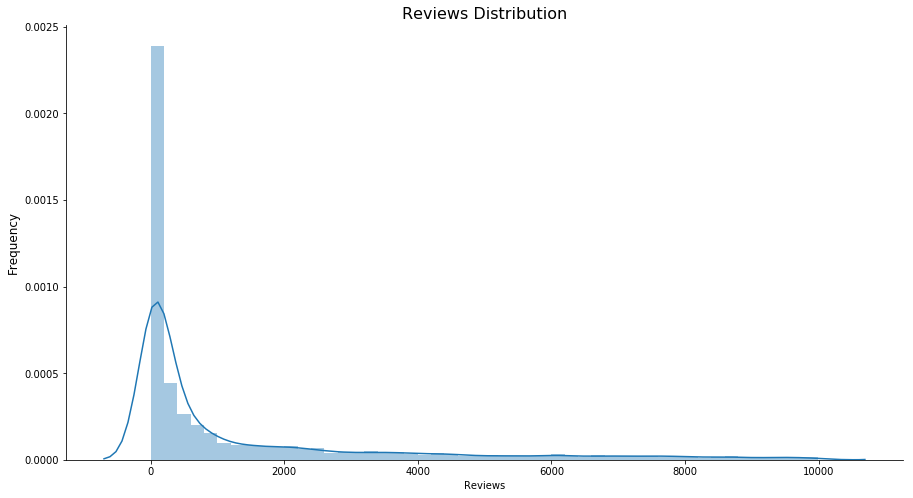

In [12]:
f, ax = plt.subplots(figsize=(15, 8))
sns.despine(f)
sns.distplot(df[df['Reviews']<1e4]['Reviews'], kde=True)
# sns.kdeplot(df[df['Reviews']<1e4]['Reviews'], shade=True)
plt.title('Reviews Distribution', size=16)
plt.ylabel('Frequency', size=12)

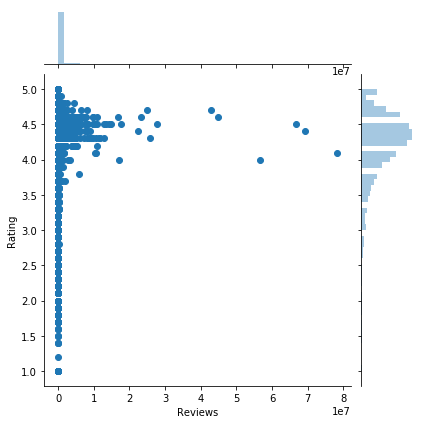

In [13]:
sns.jointplot('Reviews', 'Rating', df)

It Seems that app with more reviews tends to get better ratings.

## 2.4 Size - Rating

In [14]:
df.Size.unique()

array(['19M', '14M', '8.7M', '25M', '2.8M', '5.6M', '29M', '33M', '3.1M',
       '28M', '12M', '20M', '21M', '37M', '5.5M', '17M', '39M', '31M',
       '4.2M', '23M', '6.0M', '6.1M', '4.6M', '9.2M', '5.2M', '11M',
       '24M', 'Varies with device', '9.4M', '15M', '10M', '1.2M', '26M',
       '8.0M', '7.9M', '56M', '57M', '35M', '54M', '201k', '3.6M', '5.7M',
       '8.6M', '2.4M', '27M', '2.7M', '2.5M', '7.0M', '16M', '3.4M',
       '8.9M', '3.9M', '2.9M', '38M', '32M', '5.4M', '18M', '1.1M',
       '2.2M', '4.5M', '9.8M', '52M', '9.0M', '6.7M', '30M', '2.6M',
       '7.1M', '22M', '6.4M', '3.2M', '8.2M', '4.9M', '9.5M', '5.0M',
       '5.9M', '13M', '73M', '6.8M', '3.5M', '4.0M', '2.3M', '2.1M',
       '42M', '9.1M', '55M', '23k', '7.3M', '6.5M', '1.5M', '7.5M', '51M',
       '41M', '48M', '8.5M', '46M', '8.3M', '4.3M', '4.7M', '3.3M', '40M',
       '7.8M', '8.8M', '6.6M', '5.1M', '61M', '66M', '79k', '8.4M',
       '3.7M', '118k', '44M', '695k', '1.6M', '6.2M', '53M', '1.4M',
      

In [15]:
df['Size'].replace('Varies with device', np.nan, inplace = True )
df.Size = (df.Size.replace(r'[kM]+$', '', regex=True).astype(float) * \
            df.Size.str.extract(r'[\d\.]+([KM]+)', expand=False)
            .fillna(1).replace(['k','M'], [10**3, 10**6]).astype(int))

In [16]:
df['Size'].fillna(df.groupby('Category')['Size'].transform('mean'),inplace = True)

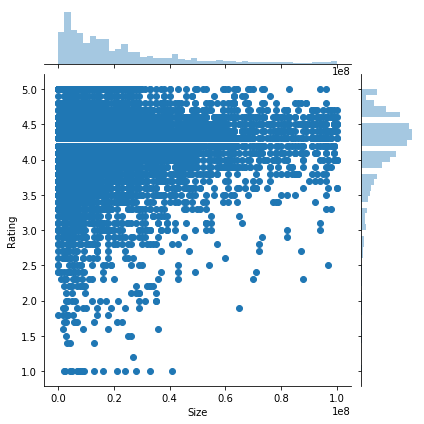

In [17]:
sns.jointplot('Size', 'Rating', df)

## 2.5 Installs - Rating

In [18]:
df_inst = df
installs_transform = {}
for i in list(df_inst['Installs'].unique()):
    installs_transform[i] = math.log(int(i[:-1].replace(',', '')))
df_inst = df_inst.replace({'Installs': installs_transform})

In [19]:
df_inst['Installs'].describe()

count    8190.000000
mean       11.794197
std         3.697382
min         0.000000
25%         9.210340
50%        11.512925
75%        13.815511
max        20.723266
Name: Installs, dtype: float64

Text(0.5, 1.0, 'Rating VS Installs')

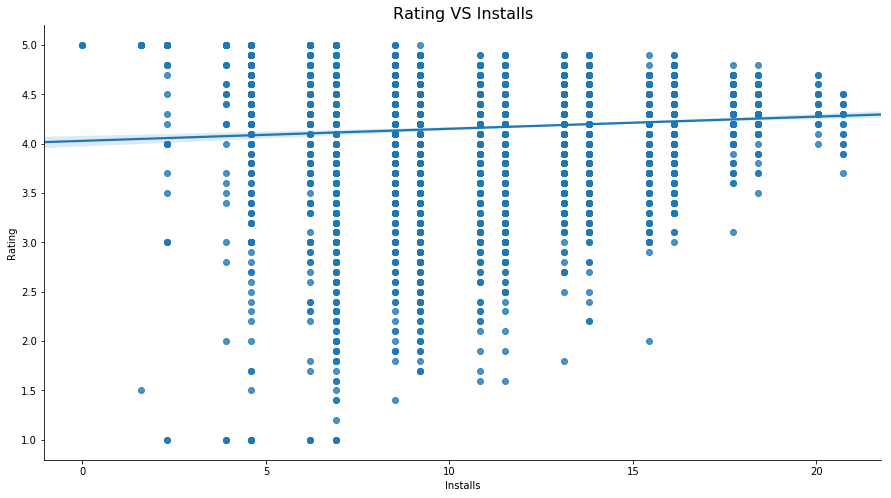

In [20]:
f, ax = plt.subplots(figsize=(15, 8))
sns.despine(f)
sns.regplot(x="Installs", y="Rating", data=df_inst);
plt.title('Rating VS Installs',size = 16)

App with more installs tends to have better ratings.

## 2.6 Type - Rating

Text(0.5, 1.0, 'Type vs Ratings')

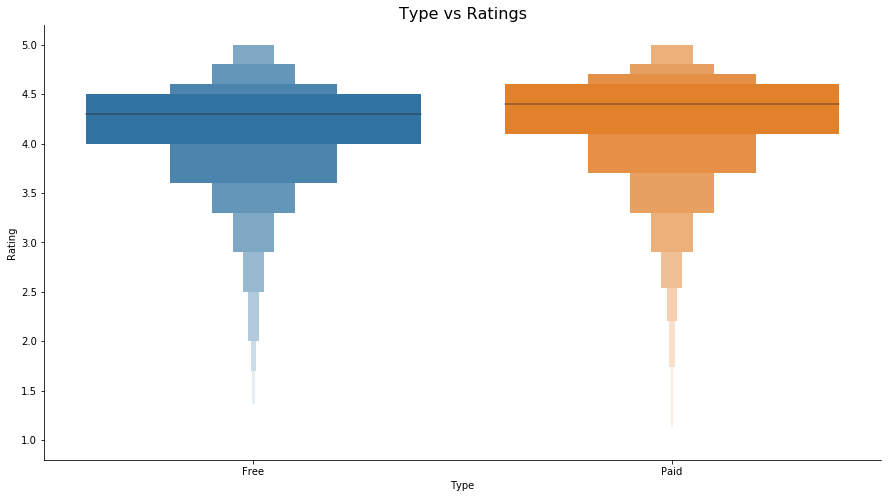

In [21]:
f, ax = plt.subplots(figsize=(15, 8))
sns.despine(f)
sns.boxenplot(x='Type', y='Rating', data=df)
plt.title('Type vs Ratings',size = 16)

Text(0.5, 1.0, 'Percentage of each Type')

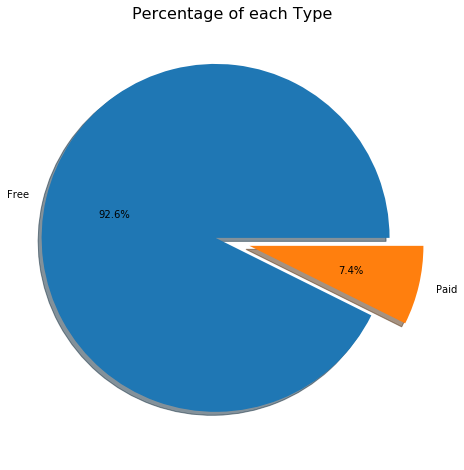

In [22]:
plt.subplots(figsize=(15, 8))
plt.pie(df['Type'].value_counts(), explode=[0.1, 0.1], labels=['Free', 'Paid'], autopct='%1.1f%%', shadow=True)
plt.title('Percentage of each Type', size=16)

## 2.7 Price vs Rating

In [23]:
df_paid = df[df['Type'] == 'Paid']
price_pair = {}
for price in list(df_paid['Price'].unique()):
    price_pair[price] = float(price[1:])
df_paid = df_paid.replace({'Price': price_pair})

In [24]:
df_paid[df_paid['Price']>100].head(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
4197,most expensive app (H),FAMILY,4.3,6,1500000.0,100+,Paid,399.99,Everyone,Entertainment,"July 16, 2018",1.0,7.0 and up
4362,💎 I'm rich,LIFESTYLE,3.8,718,26000000.0,"10,000+",Paid,399.99,Everyone,Lifestyle,"March 11, 2018",1.0.0,4.4 and up
4367,I'm Rich - Trump Edition,LIFESTYLE,3.6,275,7300000.0,"10,000+",Paid,400.00,Everyone,Lifestyle,"May 3, 2018",1.0.1,4.1 and up
5351,I am rich,LIFESTYLE,3.8,3547,1800000.0,"100,000+",Paid,399.99,Everyone,Lifestyle,"January 12, 2018",2.0,4.0.3 and up
5354,I am Rich Plus,FAMILY,4.0,856,8700000.0,"10,000+",Paid,399.99,Everyone,Entertainment,"May 19, 2018",3.0,4.4 and up


Text(0.5, 1.0, 'Price VS Ratings')

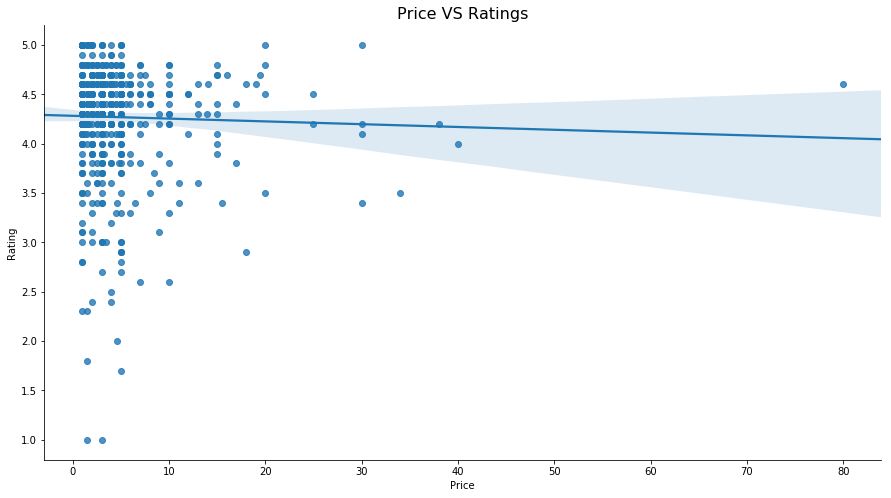

In [25]:
f, ax = plt.subplots(figsize=(15, 8))
sns.despine(f)
sns.regplot(x="Price", y="Rating", data=df_paid[df_paid['Price']<100]);
plt.title('Price VS Ratings',size = 16)

Apps with higher price are more likely to disappointed customers.

## 2.8 Genres vs Rating

In [26]:
df['Genres'].unique()

array(['Art & Design', 'Art & Design;Pretend Play',
       'Art & Design;Creativity', 'Auto & Vehicles', 'Beauty',
       'Books & Reference', 'Business', 'Comics', 'Comics;Creativity',
       'Communication', 'Dating', 'Education;Education', 'Education',
       'Education;Creativity', 'Education;Music & Video',
       'Education;Action & Adventure', 'Education;Pretend Play',
       'Education;Brain Games', 'Entertainment',
       'Entertainment;Music & Video', 'Entertainment;Brain Games',
       'Entertainment;Creativity', 'Events', 'Finance', 'Food & Drink',
       'Health & Fitness', 'House & Home', 'Libraries & Demo',
       'Lifestyle', 'Lifestyle;Pretend Play',
       'Adventure;Action & Adventure', 'Arcade', 'Casual', 'Card',
       'Casual;Pretend Play', 'Action', 'Strategy', 'Puzzle', 'Sports',
       'Music', 'Word', 'Racing', 'Casual;Creativity',
       'Casual;Action & Adventure', 'Simulation', 'Adventure', 'Board',
       'Trivia', 'Role Playing', 'Simulation;Education',
 

Text(0.5, 1.0, 'Genres Count')

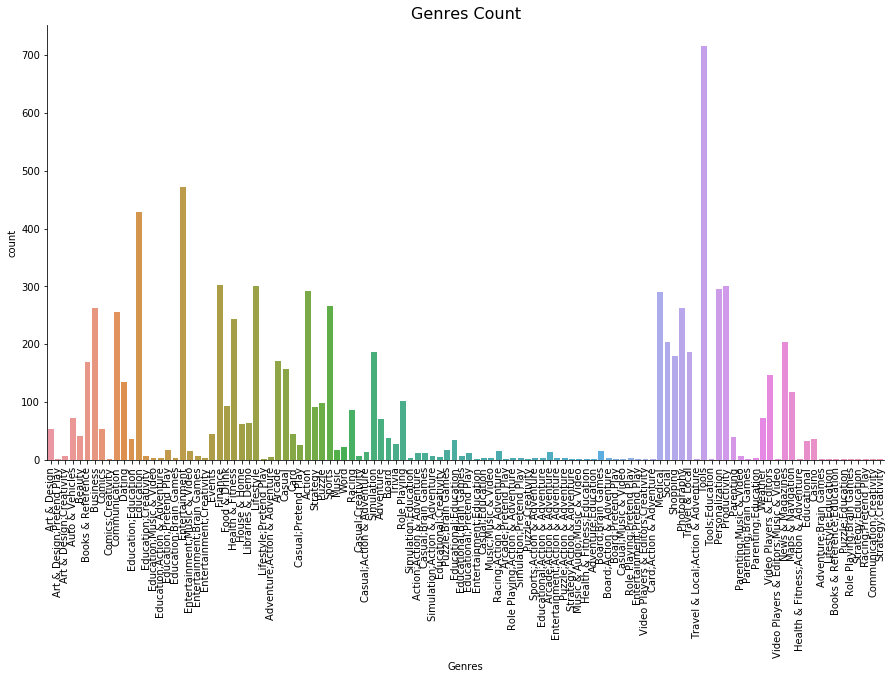

In [27]:
f, ax = plt.subplots(figsize=(15, 8))
sns.despine(f)
sns.countplot('Genres', data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title('Genres Count', size=16)

In [28]:
df_genres = df
for genre in df['Genres'].unique():
    if df['Genres'].value_counts()[genre] < 100:
        df_genres = df_genres[df_genres['Genres']!=genre]

Text(0.5, 1.0, 'Genres Count')

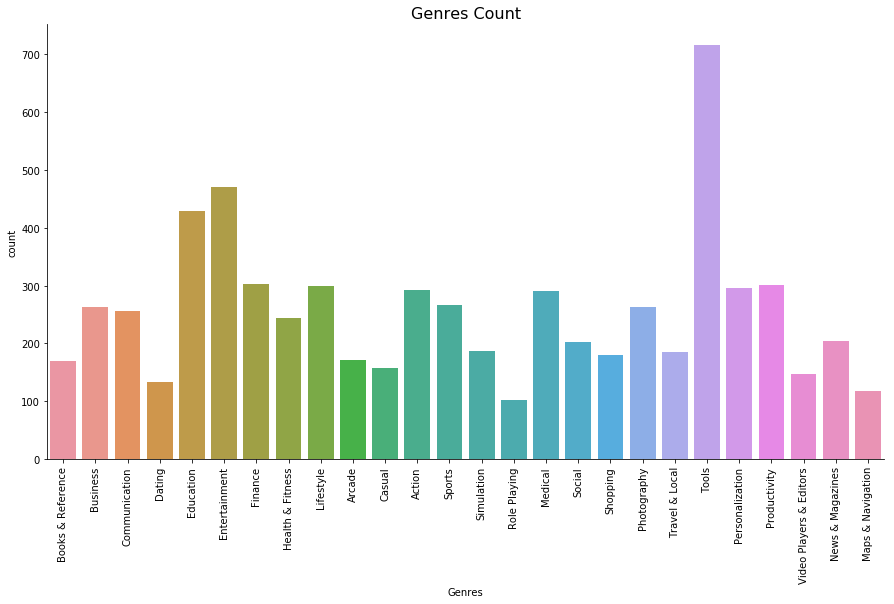

In [29]:
f, ax = plt.subplots(figsize=(15, 8))
sns.despine(f)
sns.countplot('Genres', data=df_genres)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title('Genres Count', size=16)

Text(0.5, 1.0, 'Rating vs Genres')

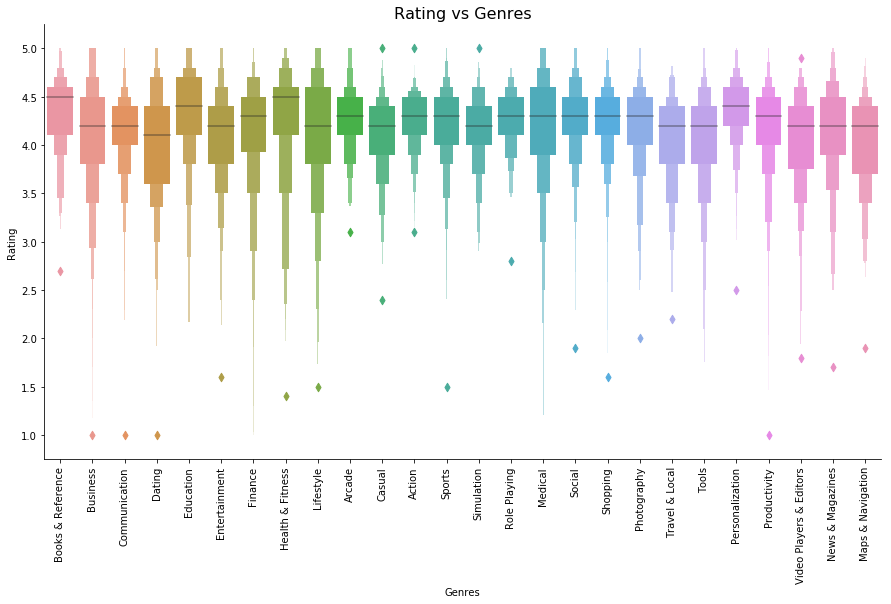

In [30]:
f, ax = plt.subplots(figsize=(15, 8))
sns.despine(f)
sns.boxenplot(x='Genres', y='Rating', data=df_genres)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title('Rating vs Genres', size=16)

# 3. Preprocessing and Prediction

In [31]:
#preprocessing
df = pd.read_csv('googleplaystore.csv')
df = df.drop(['Current Ver', 'Genres', 'Android Ver'], axis = 1)
df = df.dropna()
df = df[(df['Content Rating'] == 'Everyone')].copy()

In [32]:
def standardize_Installs(inputstring):
    outputstring = inputstring.replace('+', '')
    outputstring = outputstring.replace(',', '')
    outputstring = int(outputstring)
    return outputstring
def standardize_Reviews(inputstring):
    outputstring = int(inputstring)
    return outputstring
def standardize_Price(inputstring): 
    outputstring = inputstring.replace('$', '') 
    outputstring = float(outputstring)
    return outputstring
def standardize_Type(inputstring):
    if inputstring == 'Free':
        outputstring = 0
    else:
        outputstring = 1
    return outputstring

In [33]:
df['Installs'] = df['Installs'].apply(standardize_Installs)
df['Reviews'] = df['Reviews'].apply(standardize_Reviews)
df['Price'] = df['Price'].apply(standardize_Price)
df['Type'] = df['Type'].apply(standardize_Type)
df = pd.get_dummies(df, columns=['Category'])

In [34]:
df['Last Updated'] = df['Last Updated'].apply(lambda x : time.mktime(datetime.datetime.strptime(x, '%B %d, %Y').timetuple()))
k_indices = df['Size'].loc[df['Size'].str.contains('k')].index.tolist()
converter = pd.DataFrame(df.loc[k_indices, 'Size'].apply(lambda x: x.strip('k')).astype(float).apply(lambda x: x / 1024).apply(lambda x: round(x, 3)).astype(str))
df.loc[k_indices,'Size'] = converter
df['Size'] = df['Size'].apply(lambda x: x.strip('M'))
df = df[(df['Size'] != 'Varies with device')].copy()
# df[df['Size'] == 'Varies with device'] = 0
df['Size'] = df['Size'].astype(float)

In [35]:
# select features that may affect the rate
X = df.drop(labels = ['App', 'Rating', 'Content Rating'], axis = 1)
y = df.Rating

In [37]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 10)
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

/Users/luojiayi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/luojiayi/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/luojiayi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """


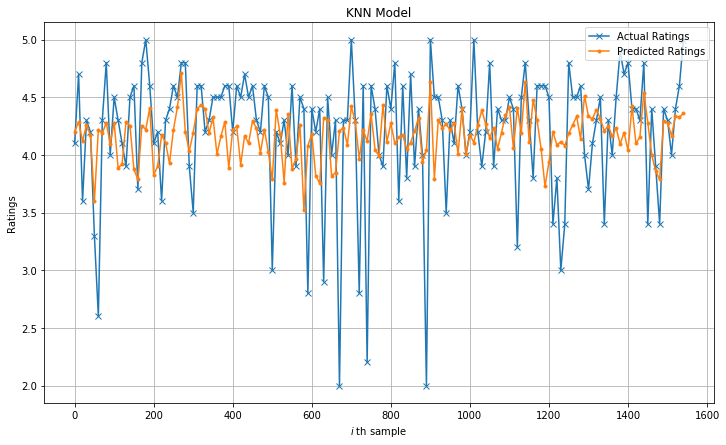

R^2 = 0.012434125065150736
MSE = 0.3249971340102254


In [38]:
# KNN Model
model1 = KNeighborsRegressor(n_neighbors=15)
model1.fit(X_train, y_train)
y_predict1 = model1.predict(X_test)

# visualize predictions
plt.figure(figsize = (12, 7))
x = np.arange(0, len(y_test), 10)
p1 = plt.plot(x, np.array(y_test)[x], marker = 'x', label = 'Actual Ratings')
p2 = plt.plot(x, np.array(y_predict1)[x], marker = '.', label = 'Predicted Ratings')
plt.legend(loc = 1)
plt.grid()
plt.title('KNN Model')
plt.xlabel(r'$\mathit{i}$' + ' th sample')
plt.ylabel('Ratings')
plt.show()

# evaluation 
ACC1 = model1.score(X_test, y_test)
MSE1 = metrics.mean_squared_error(y_test, y_predict1)
print('R^2 = ' + str(ACC1))
print('MSE = ' + str(MSE1))

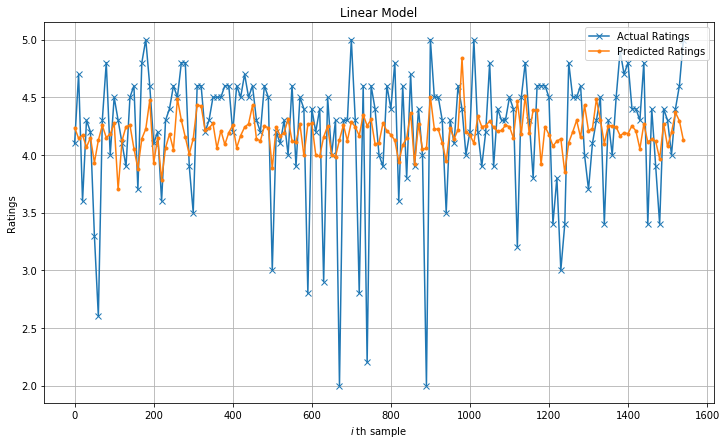

R^2 = 0.04586819067926884
MSE = 0.3139943484961805


In [39]:
# Linear Regression Model
model2 = LinearRegression()
model2.fit(X_train, y_train)
y_predict2 = model2.predict(X_test)

# visualize predictions
plt.figure(figsize = (12, 7))
x = np.arange(0, len(y_test), 10)
p1 = plt.plot(x, np.array(y_test)[x], marker = 'x', label = 'Actual Ratings')
p2 = plt.plot(x, np.array(y_predict2)[x], marker = '.', label = 'Predicted Ratings')
plt.legend(loc = 1)
plt.grid()
plt.title('Linear Model')
plt.xlabel(r'$\mathit{i}$' + ' th sample')
plt.ylabel('Ratings')
plt.show()

# evaluation
ACC2 = model2.score(X_test, y_test)
MSE2 = metrics.mean_squared_error(y_test, y_predict2)
print('R^2 = ' + str(ACC2))
print('MSE = ' + str(MSE2))

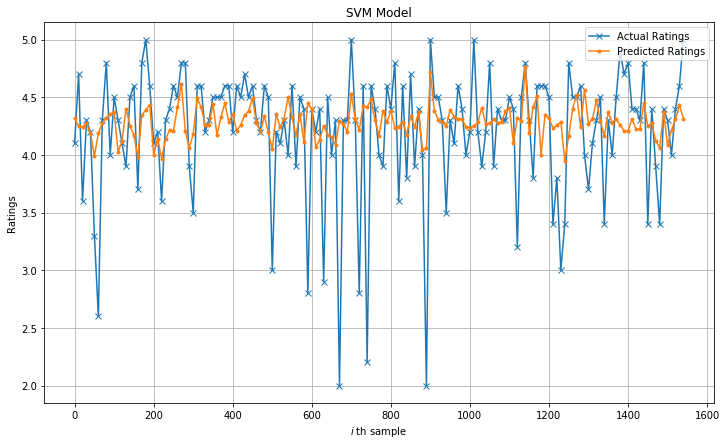

R^2 = 0.02036779587232007
MSE = 0.3223862496733393


In [40]:
# SVM Model
model3 = svm.SVR()
model3.fit(X_train, y_train)
y_predict3 = model3.predict(X_test)

# visualize predictions
plt.figure(figsize = (12, 7))
x = np.arange(0, len(y_test), 10)
p1 = plt.plot(x, np.array(y_test)[x], marker = 'x', label = 'Actual Ratings')
p2 = plt.plot(x, np.array(y_predict3)[x], marker = '.', label = 'Predicted Ratings')
plt.legend(loc = 1)
plt.grid()
plt.title('SVM Model')
plt.xlabel(r'$\mathit{i}$' + ' th sample')
plt.ylabel('Ratings')
plt.show()

# evaluation
ACC3 = model3.score(X_test, y_test)
MSE3 = metrics.mean_squared_error(y_test, y_predict3)
print('R^2 = ' + str(ACC3))
print('MSE = ' + str(MSE3))

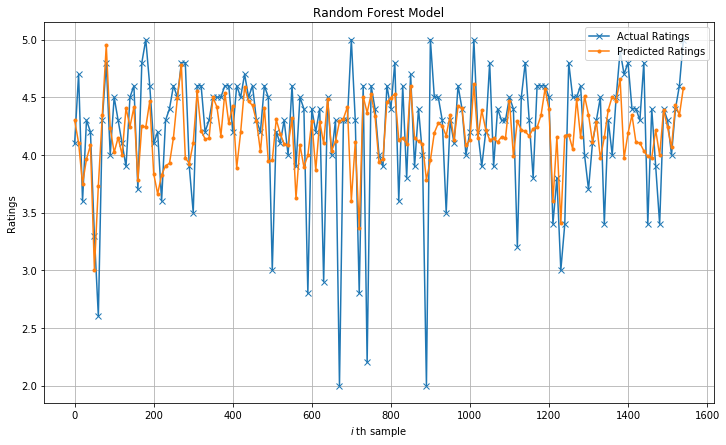

R^2 = 0.16616947659695747
MSE = 0.2744045103564485


In [41]:
# Random Forest Model
model4 = RandomForestRegressor(n_estimators = 500)
model4.fit(X_train, y_train)
y_predict4 = model4.predict(X_test)

# visualize predictions
plt.figure(figsize = (12, 7))
x = np.arange(0, len(y_test), 10)
p1 = plt.plot(x, np.array(y_test)[x], marker = 'x', label = 'Actual Ratings')
p2 = plt.plot(x, np.array(y_predict4)[x], marker = '.', label = 'Predicted Ratings')
plt.legend(loc = 1)
plt.grid()
plt.title('Random Forest Model')
plt.xlabel(r'$\mathit{i}$' + ' th sample')
plt.ylabel('Ratings')
plt.show()

# evaluation
ACC4 = model4.score(X_test, y_test)
MSE4 = metrics.mean_squared_error(y_test, y_predict4)
print('R^2 = ' + str(ACC4))
print('MSE = ' + str(MSE4))

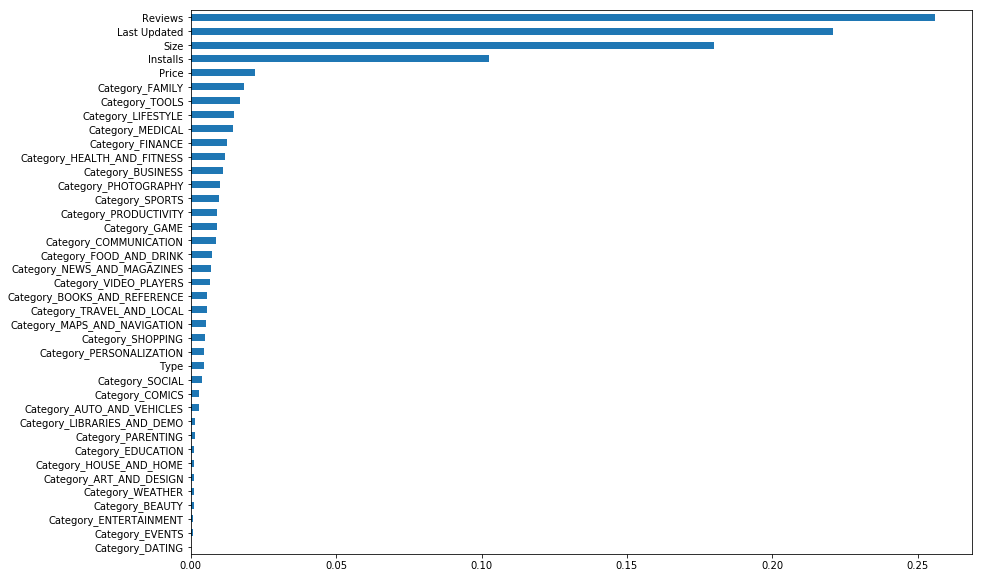

In [42]:
# plot feature weights
feature_weights = pd.Series(data = model4.feature_importances_, index = X.columns)
plt.figure(figsize = (14, 10))
feature_weights.sort_values().plot.barh()
plt.show()

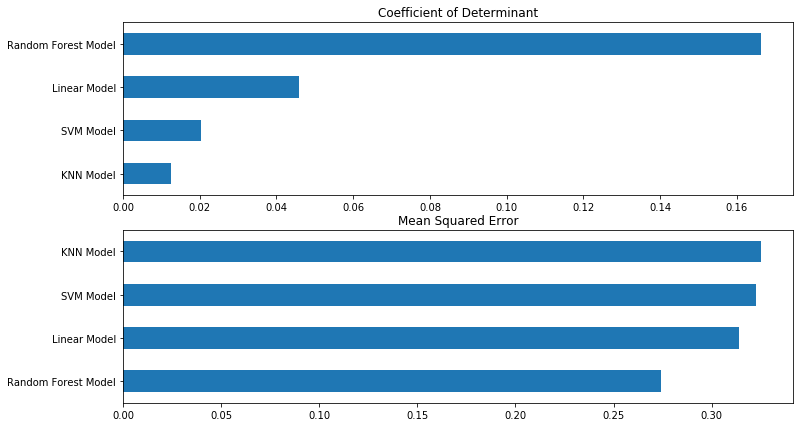

In [43]:
# compare models with metrics R^2 and MSE
model_names = ['KNN Model', 'Linear Model', 'SVM Model', 'Random Forest Model']
ACC = pd.Series(data = [ACC1, ACC2, ACC3, ACC4], index = model_names)
MSE = pd.Series(data = [MSE1, MSE2, MSE3, MSE4], index = model_names)
plt.figure(figsize=(12,7))
plt.subplot(2,1,1)
ACC.sort_values().plot.barh()
plt.title('Coefficient of Determinant')
plt.subplot(2,1,2)
MSE.sort_values().plot.barh()
plt.title('Mean Squared Error')
plt.show()